# Diseño del sistema de control del atitud de un satélite

## Definimos el sistema:

In [1]:
import numpy as np
import control as ctrl
import matplotlib.pyplot as plt
%matplotlib inline

Diseñar un compensador para la planta: 

$$ \dot{\mathbf{x}}=\begin{bmatrix}
0&1\\
0&0\\
\end{bmatrix}\mathbf{x}+\begin{bmatrix}
0\\
1
\end{bmatrix}u$$
$$ y=\begin{bmatrix}
1&0\end{bmatrix}\mathbf{x}.$$

que ubique los polos tal que $\omega_n =1$ y $\zeta=0.707$:

In [2]:
A=[[0,1],[0,0]]
B=[[0],[1]]
C=[[1,0]]
D=[[0]]
sys=ctrl.ss(A,B,C,D)

## Análisis de Controlalibidad y Observabilidad

Vemos que el sistema es controlable usando las matrices C y B  dadas. Aunque no lo sería se fuesen diferentes (es decir se actuara o se midiera diferente).

In [3]:
print(np.linalg.matrix_rank(ctrl.obsv(A,C)))

print(np.linalg.matrix_rank(ctrl.obsv(A,[[0,1]])))

print(np.linalg.matrix_rank(ctrl.ctrb(A,B)))

print(np.linalg.matrix_rank(ctrl.ctrb(A,[[1],[0]])))

2
1
2
1


Para cumplir con los requerimientos debemos ubicar los polos en $\alpha_c = -0.7070 \pm 0.0707j$.

## Ley de Control

Usando el comando `acker` o `place` obtenemos la ley de control que ubica los polos del sistema donde queremos.

In [4]:
wnc=1
zetac=np.sqrt(2)/2
polyc=[1,2*zetac*wnc,wnc**2]
alpha_c =np.roots(polyc)
print(alpha_c)

[-0.70710678+0.70710678j -0.70710678-0.70710678j]


In [5]:
K = ctrl.place(A,B,alpha_c)
print(K)

[[1.         1.41421356]]


Usando `acker`

In [6]:
K = ctrl.acker(A,B,alpha_c)
print(K)


[[1.         1.41421356]]


Controlamos que las cuentas esten bien hechas, viendo que los autovalores de $\mathbf{A}-\mathbf{BK}$ den donde tienen que dar:

In [7]:
l,_=np.linalg.eig(A-B@K)
print(l)

[-0.70710678+0.70710678j -0.70710678-0.70710678j]


## Diseño del estimador

Ahora ubicamos los polos del estimador 5 veces más rápido, pero con un $\zeta$ que haga que no oscile ($\zeta=0.5$).

In [8]:
wne=5
zetae=0.5
polye =[1,2*zetae*wne,wne**2]
rootse=np.roots(polye)
print(rootse)

[-2.5+4.33012702j -2.5-4.33012702j]


In [9]:
Lt=ctrl.place(sys.A.T,sys.C.T,rootse).T
print(Lt)

[[ 5.]
 [25.]]


## Definición del sistema de control

Expresando las ecuaciones de estado del controlador $D_c$ nos queda:
$$\begin{eqnarray}
\mathbf{\dot{\hat{x}}}&=&(\mathbf{A-BK-LC}) \mathbf{\hat {x}}+\mathbf{L}y\\
u&=&-\mathbf{K}\mathbf{\hat{x}}\end{eqnarray}$$


In [10]:
Dc=ctrl.ss(A-B@K-Lt@C,Lt,-K,[0])
ctrl.tf(Dc)


    -40.36 s - 25
---------------------
s^2 + 6.414 s + 33.07

Con este controlador podemos hacer un análisis de sistema igual que lo hacíamos con control clásico.

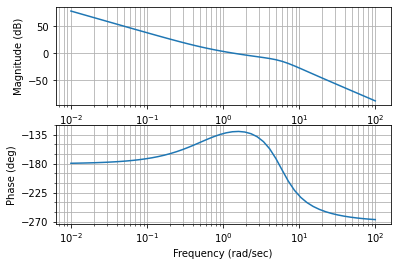

In [11]:
_=ctrl.bode(sys*-Dc,dB=True)


In [12]:
ctrl.margin(sys*-Dc)

(4.624852080148199, 49.924961784142084, 5.394208336492233, 1.3670031280375041)

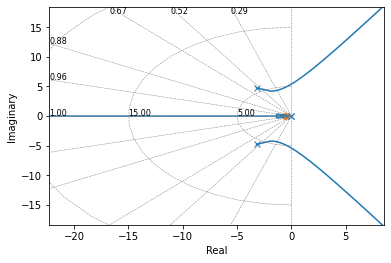

In [13]:
_=ctrl.rlocus(sys*-Dc,grid=True)

Podemos ver que este diseño tiene un margen de fase de 50 grados aproximadamente.

## Con estimador reducido

Pondremos ahora el polo del estimador en -5rad/seg.

In [14]:
polesered=[-5]
Aaa=sys.A[0:1,0:1]
Aab=sys.A[0:1,1:]
Aba=sys.A[1:,0:1]
Abb=sys.A[1:,1:]

Ba = sys.B[0:1,0]
Bb = sys.B[1:,0]


In [15]:
Ltred = ctrl.acker(Abb.T,Aab.T,polesered).T
Ltred

matrix([[5.]])

Ahora podemos obtener la ley de control igualmente mediante estas ecuaciones del controlador para un sistema con un estimador reducido.

Para esto necesitamos devidir las $\mathbf K$ que multiplican a la parte medida de los esatados ($\mathbf{K_a}$) de la no medida ($\mathbf{K_b}$).


## Definición del sistema  controlador con estimador de orden reducido

In [16]:
Ka=K[0,0:1]
Kb=K[0,1:]

Ar = Abb-Ltred@Aab-(Bb-Ltred@Ba)*Kb
Br = Ar@Ltred + Aba - Ltred@Aaa - (Bb-Ltred@Ba)@Ka
Cr = -Kb
Dr = -Ka-Kb@Ltred

In [17]:
Dcr = ctrl.ss(Ar,Br,Cr,Dr)

In [18]:
ctrl.tf(-Dcr)


8.071 s + 5
-----------
 s + 6.414

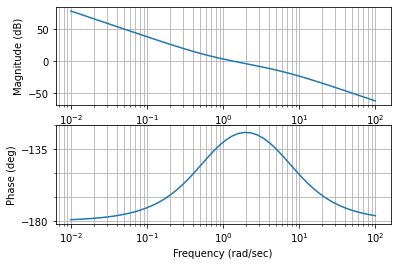

In [19]:
_=ctrl.bode((-Dcr*sys),dB=True)

In [20]:
ctrl.margin(-Dcr*sys)

(9.769962616701384e-16, 53.494190654187605, 0.0, 1.3539367069138153)

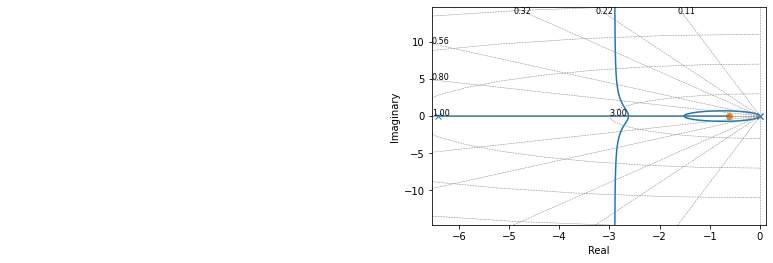

In [21]:
_=ctrl.rlocus(-Dcr*sys)